## __SENTIMENT ANALYSIS IMPLEMENTATION__<hr>

### Import Libraries<hr>
We will use *pandas* and *numpy* for data manipulation, *nltk* for NLP, *matplotlib*, *seaborn*, and *plotly* for data visualization, *sklearn* (Multinomial Naive Bayes) and *keras* (LSTM) for training the model.

In [1]:
import pandas as pd
import numpy as np
import string, re
import itertools
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import stopwordsiso as stopwords
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
import tensorflow as tf
import ipynb.fs.defs.preprocessing as prep
py.init_notebook_mode(connected=True)
%matplotlib inline

### Setting the Random Seed<hr>
This is to make the output of the models more consistent with the given inputs. Note that since the models are affected by random seeds, we can set the seeds to a constant number (not specifically the same value for all random seeds).

In [2]:
# import os
# import random

# seed = 3000
# os.environ['PYTHONHASHSEED']=str(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# random.seed(seed)

### Load the datasets<hr>
 
The datasets found in `/data` folder were loaded. The datasets comprise collected tweets from twitter (`twitter.csv`), posts from facebook (`facebook.csv`), and additional data also extracted from twitter (`random.csv`).
 
The fields of each record are as follows.
 
  - `Raw`: The original (raw) tweet/post. Did not undergo any form of modification or correction.
  - `Raw_Translated`: The raw tweet/post translated to English via Google Translate.
  - `Clean`: Modified (clean) version of the raw tweet/post. Undergone manual spelling and grammar correction.
  - `Clean_Translated`: The clean tweet/post translated to English via Google Translate.
  - `Tag`: Contains $0$ if the tweet/post is harmless, $1$ if the tweet/post is harmful.
 
The records read from different .csv files were combined using `concat([twitter, facebook, rand])` and shuffled using `shuffle(df)`.

In [3]:
twitter = pd.read_csv('../data/twitter.csv', usecols=[3,4])
facebook = pd.read_csv('../data/facebook.csv', usecols=[3,4])
rand = pd.read_csv('../data/random.csv', usecols=[3,4])
df = pd.concat([twitter, facebook, rand])
df = shuffle(df)
df.head()

,Clean_Translated,Tag
584,It is true that there is a collectible 203B es...,1
166,Doc may be mad,1
528,My heart goes out to Tyang Aby's no -man Bolic...,1
165,Do just hope no die,0
374,Win: Kuya Byron,0


### Data Analysis - Statistics
 
The next cell checks the shape of the data set. The expected number of records from `twitter.csv` is $817$, $501$ from `facebook.csv`, and $1010$ from `random.csv`. All together, the total number of records is $2328$.

In [4]:
print(twitter.shape)
print(facebook.shape)
print(rand.shape)
print(df.shape)

(817, 2)
(501, 2)
(1010, 2)
(2328, 2)


`isna()` was used to check if there are missing values in each record. There may be cells full of special characters, emojis, punctuation, links, mentions, etc. that have not been read correctly or read as empty.

In [5]:
# No missing values
twitter[twitter.isna().any(axis=1)]
facebook[facebook.isna().any(axis=1)]
rand[rand.isna().any(axis=1)]
df[df.isna().any(axis=1)]

,Clean_Translated,Tag


### Statistic<hr>
The data sets contains $817$ entries for twitter (tweets), $501$ entries for facebook (posts and comments), and $1010$ entries for additional test data retrieved using the twitter API.

For every sentence/text in the data set, the lengths of these are taken. `lens` is the length of all sentences (by character number) in the dataset. Using this, we can get the __mean value__, __standard deviation__, __minimum__, and __maximum__ of these lengths as shown below:

In [6]:
lens = df['Clean_Translated'].str.len()
print(lens.mean(), lens.std(), lens.min(), lens.max())

53.29896907216495 43.697016748054416 1 277


Distribution of tweets and post length:

Using the `plotly` module, a histogram is built using `graph_objs.Histogram` to store the data (`lens`) and `graph_objs.Layout` to form the layout of the graph. The figure is then created and rendered using `graph.Figure` and `offline.iplot`. The data shows that most sentences are around 10-39 characters long.

In [7]:
data = [go.Histogram(x=lens, xbins=dict(start=0, end=8000, size=10), marker=dict(color='#8c42f4'))]
layout = go.Layout(
                  title='Length of tweets and post distribution',                  
                  xaxis=dict(title='Length'),
                  yaxis=dict(title='Count'),
                  bargap=0.1)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='length histogram')

Correlate length and sentiment marks:

The data is then checked for correlation between the length of these sentences/text with the sentiment tagged together with the data. The figure below is a scatter plot (using the `plotly` module) where the $x$ values are the length of the text and the $y$ values are the sentiments. The lengths are mostly clumped within the $0-100$ range.

In [8]:
df['Text_Length'] = df['Clean_Translated'].apply(lambda x: len(x))
data = df.sort_values(by='Text_Length')
plot = go.Scatter(x = data['Text_Length'], y = data['Tag'], mode='markers')
lyt = go.Layout(title="Length vs. Sentiment Label", xaxis=dict(title='Review Length'),yaxis=dict(title='Label'))
fig = go.Figure(data=[plot], layout=lyt)
py.iplot(fig)

Pearson correlation:

The Pearson correlation is a statistical tool used to check for statistical relationship, or association, between two continuous variables. In this case, the variables that are to be compared are the tags and the text length. Notice from the figure (*heatmap*) below that the correlation between the tag and length of the is negligible with the value of $0.1$.

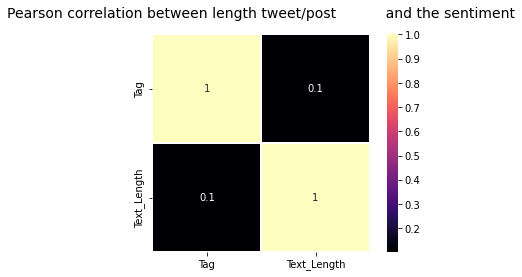

In [9]:
colormap = plt.cm.magma
plt.title('Pearson correlation between length tweet/post\
           and the sentiment', y=1.05, size=14)
sns.heatmap(data.drop(['Clean_Translated'], axis=1).astype(float).corr(),
            linewidths=0.01,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=True)
plt.show()

#### Commonly seen words in one tag:

The commonly seen words in a tag (sentiment) are given in the word cloud below for visualization purposes. We note that `df_neg` is the splice of the data set where all tags are 1 (negative) and `df_pos` is the splice of the data set where all tags are 0 (positive).

In [10]:
df_neg = df[ df['Tag'] == 1]
df_neg = df_neg['Clean_Translated']
df_pos = df[ df['Tag'] == 0]
df_pos = df_pos['Clean_Translated']

>Commonly seen in "__Negative__" sentences

Using the `wordcloud` module, the common words or phrases that are most likely seen to have negative connotations are shown in the figure below:

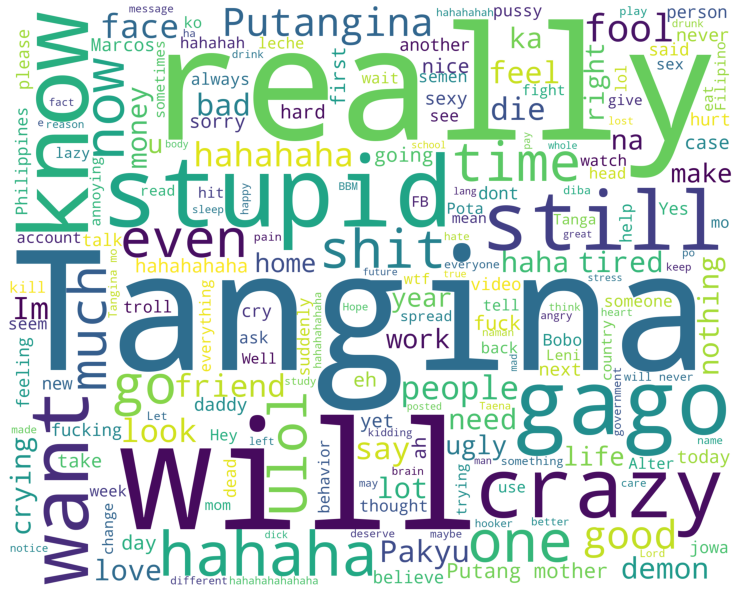

In [11]:
wordcloud1 = WordCloud(stopwords=STOPWORDS, # or stopwords.stopwords("tl") for tagalog
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_neg))
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

>Commonly seen in "__Positive__" sentences

Using the `wordcloud` module, the common words or phrases that are most likely seen to have positive connotations are shown in the figure below:

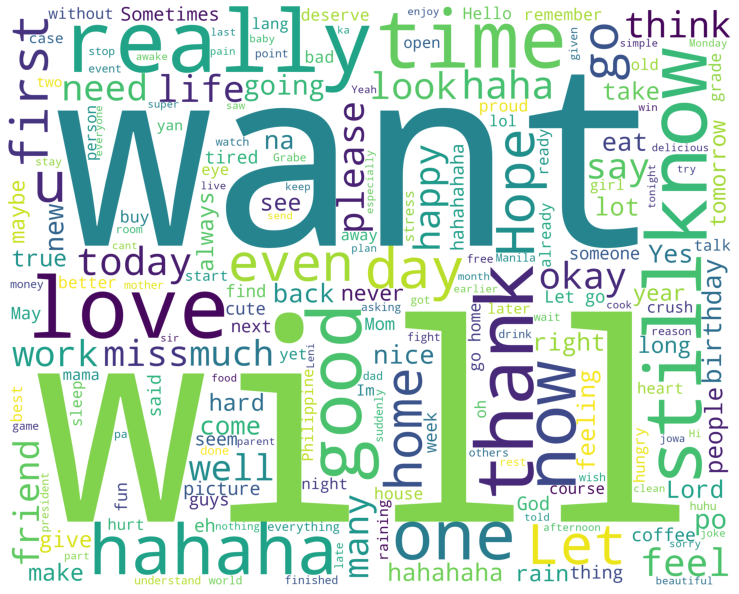

In [12]:
wordcloud2 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_pos))
plt.figure(2,figsize=(13, 13))
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

Do note that the `STOPWORDS` from the `wordcloud` module contains stopwords for only english words. Thus, the `stopwordsiso` was also added.

#### Distribution of Sentiments:
The next cell examines the distribution of sentiments throughout the data. This gives an overview of how many of the collected tweets/post are harmless, and how many are harmful. The distribution is presented in a bar graph. Note that harmless tweets/post are labelled $0$, and the harmful are labelled $1$.

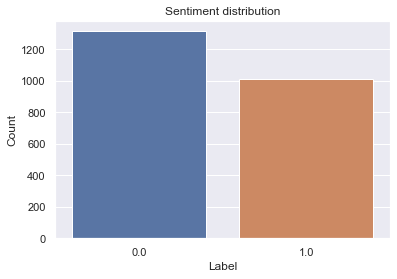

In [42]:
sns.set(style="darkgrid")
b = sns.countplot(x='Tag',
                  data = df.drop(['Clean_Translated'], axis=1).astype(float))
b.axes.set_title('Sentiment distribution')
b.set_xlabel("Label")
b.set_ylabel("Count")
plt.show()

### Text Preprocessing<hr>

The texts were preprocessed. This includes removing the special characters such as punctuations, emojis, and hashtags. Hyperlinks and mentions were also omitted. The texts were transformed to lower case.

In [43]:
df['Clean_Translated'] = df['Clean_Translated'].apply(prep.simplify_text)
df.head()

,Clean_Translated,Tag,Text_Length
584,it is true that there is a collectible 203b es...,1,130
166,doc may be mad,1,14
528,my heart goes out to tyang abys no man bolick ...,1,66
165,do just hope no die,0,19
374,win kuya byron,0,15


The shuffled data were split in a $9:1$ ratio. $90%$ of the data were allocated for training the model in order to give a more accurate fitting. The rest of the data were set aside for testing.

In [44]:
text = df['Clean_Translated']
tag = df['Tag']
text_train, text_test, tag_train, tag_test = train_test_split(text, tag, test_size=0.1)
print(text_train.shape,text_test.shape)

(2095,) (233,)


### __Naive Bayes__ - Training the Model<hr>

In order to use the data for predictive modeling, we first prepare it by `TfidfVectorizer`. The “Term Frequency – Inverse Document” Frequency method 
(a) Term Frequency: summarizes how often a given word appears within a document
(b) Inverse Document Frequency: downscales words that appear a lot across documents.

The `TfidfVectorizer` method is used to both the `text_train` and `text_test` data to tokenize, and learn the vocabulary,inverse document frequency weightings, and give a higher weight to words that occur less frequently.


Reference: https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

We use parameter $\text{min}_{\text{df}} = 2$ to filter out words that occur only once in the entire dataset.

In [45]:
vectorizer = TfidfVectorizer(min_df=2) # term frequency-inverse document frequency
train_term = vectorizer.fit_transform(text_train)
test_term = vectorizer.transform(text_test)

Shown are some of the words that will be used by the models as features based on `TfidfVectorizer` method:

In [46]:
vectorizer.get_feature_names_out()[100:120]

array(['at', 'ate', 'atleast', 'attend', 'attention', 'attitude',
       'audience', 'aunt', 'australia', 'available', 'avoid', 'awake',
       'away', 'ay', 'ayan', 'ayoko', 'ba', 'baby', 'back', 'bad'],
      dtype=object)

We could then train the Naive Bayes Model using the Multinomial Naive Bayes classifier `MultinomialNB`. This method from `sklearn.naive_bayes` is suitable for the data case where classification is based on the discrete feature which is the word count using `TfidfVectorizer`.
The Naive Bayes classifier is fit according to the train data's text `train_term` and its corresponding tag `tag_train`. Classification is then performed on both the ***normalized train data*** `train_term` and ***normalized test data*** `test_term` from the previous section.

Reference:
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#:~:text=The%20multinomial%20Naive%20Bayes%20classifier,tf%2Didf%20may%20also%20work.


In [47]:
model = MultinomialNB()
model.fit(train_term, tag_train)
predictions_train = model.predict(train_term)
predictions_test = model.predict(test_term)
print('Train Accuracy:', accuracy_score(tag_train, predictions_train))

Train Accuracy: 0.8682577565632458


#### Naive Bayes - Testing Test data
The method `accuracy_score` from `sklearn.metrics` is then used to compute for the **F1 score of the model** . This is done by computing the subset accuracy wherein the set of labels predicted for a sample must exactly match the corresponding set of labels in `tag_train` in the case of the train data and `tag_test` in the case of the test data.

Reference:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

In [48]:
print('Test Accuracy:', accuracy_score(tag_test, predictions_test))

Test Accuracy: 0.7811158798283262


### Checking for mistakes in the model<hr>

The `sklearn.metric`’s confusion matrix was used to evaluate the Naive Bayes model’s performance. This matrix helps in visualizing the count for the predicted labels, `predictions_train` and `predictions_test`, versus the true labels, `tag_train`
and `tag_test` respectively
The confusion matrix can be interpreted as the number of true positive connotations in the top left, false negative in the top right, false positive in the bottom left, and true negative in the lower right. The `plot_confusion_matrix` also has a parameter for normalizing the confusion matrix. 

Confusion matrix, without normalization
[[1126   48]
 [ 228  693]]
Confusion matrix, without normalization
[[129  13]
 [ 38  53]]


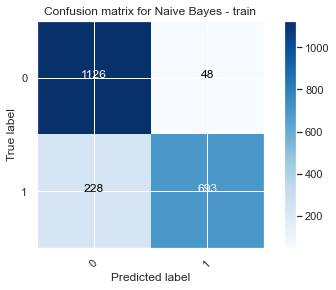

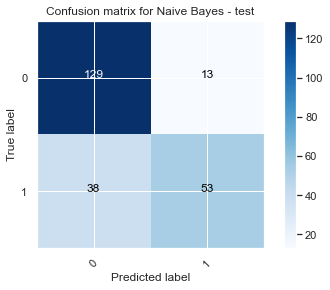

In [49]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cnf_matrix_train = confusion_matrix(tag_train, predictions_train)
cnf_matrix_test = confusion_matrix(tag_test, predictions_test)
plt.figure()
plot_confusion_matrix(cnf_matrix_train,
                      classes=[0,1],
                      title='Confusion matrix for Naive Bayes - train')
plt.figure()
plot_confusion_matrix(cnf_matrix_test,
                      classes=[0,1],
                      title='Confusion matrix for Naive Bayes - test')

### __LSTM__ - Training the Model<hr>
Next, we use the Long Short Term Memory Neural Network. For the preprocessing phase, each text in the dataset is tokenized using the `tf.keras.preprocessing.text.Tokenizer` method with the maximum number of features retrieved set to 3000. The `fit_on_texts` method updates the vocabulary to be used by the model using the phrases found in the `Clean_Translated`/`Clean`/`Raw` column of the dataset. Then, the tokens are transformed into a sequence of integers using the `texts_to_sequences` method and subsequently padded to match different text lengths using the `pad_sequences` method.

In [69]:
max_features = 5000
training = train_test_split(df, test_size = 0.1)[0]
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(training['Clean_Translated'].values)
text = tokenizer.texts_to_sequences(df['Clean_Translated'].values)
text = pad_sequences(text)

We can then build the model using the Keras library. The LSTM model is first initialized using the Keras’ `Sequential` class followed by the addition of $3$ layer instances to the layer stack:
* Embedding Layer - Takes in the integer tokens generated	 from the previous cell
* LSTM Layer - A $16$ unit layer that processes the output from the embedding layer and handles weight updates for each word in the vocabulary.
* Dense Layer - Takes in the output from the LSTM layer and has a $1$ output neuron with a sigmoid activation function.

`Binary_crossentropy` loss, since the model classifies data through Binary ($0$ or $1$), and `Adam optimizer`, an efficient weight optimization algorithm, are then used to train the model. In a general sense, optimizers update the model by modifying attributes of the models of a neural network (e.g. weights and learning rates). First note that stochastic gradient descent optimizes an objective function, which in this case is the model. In a sense, it is a probabilistic approximation of gradient descent. Each step in a __SGD__ calculates the gradient for one observation picked at random instead of the whole dataset. Adam optimizer is a combination of two __SGD__ methodologies.


In [70]:
embed_dim = 64
lstm_out = 16
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=text.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dense(1,activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 55, 64)            320000    
                                                                 
 lstm_6 (LSTM)               (None, 16)                5184      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 325,201
Trainable params: 325,201
Non-trainable params: 0
_________________________________________________________________
None


We split the tag and text values and check the size of the testing and training data set.

In [71]:
tag = df['Tag'].values
text_train, text_test, tag_train, tag_test = train_test_split(text,tag, test_size = 0.1)
print(text_train.shape,tag_train.shape)
print(text_test.shape,tag_test.shape)

(2095, 55) (2095,)
(233, 55) (233,)


We train with a batch size of $16$ and train for $6$ epoch. The performance of the model is measured on the validation dataset.

In [72]:

batch_size = 16
model.fit(text_train,
          tag_train,
          epochs=6,
          batch_size=batch_size,
          validation_data=(text_test, tag_test),
          callbacks = [EarlyStopping(monitor='val_accuracy',
                       min_delta=0.001,
                       patience=10,
                       verbose=1)]
           )

Epoch 1/6
131/131 [==============================] - 6s 27ms/step - loss: 0.6737 - accuracy: 0.5800 - val_loss: 0.6455 - val_accuracy: 0.6137
Epoch 2/6
131/131 [==============================] - 2s 18ms/step - loss: 0.5056 - accuracy: 0.7733 - val_loss: 0.5464 - val_accuracy: 0.7468
Epoch 3/6
131/131 [==============================] - 3s 22ms/step - loss: 0.2731 - accuracy: 0.9064 - val_loss: 0.5919 - val_accuracy: 0.7167
Epoch 4/6
131/131 [==============================] - 3s 21ms/step - loss: 0.1576 - accuracy: 0.9442 - val_loss: 0.6201 - val_accuracy: 0.7682
Epoch 5/6
131/131 [==============================] - 3s 21ms/step - loss: 0.0988 - accuracy: 0.9666 - val_loss: 0.6645 - val_accuracy: 0.7382
Epoch 6/6
131/131 [==============================] - 3s 26ms/step - loss: 0.0712 - accuracy: 0.9771 - val_loss: 0.7555 - val_accuracy: 0.7554


Check the accuracy of predictions of the LSTM model:

Treshhold of 0.5 (negative if less than 0.5)

In [73]:
predictions_nn_train = model.predict(text_train)
predictions_nn_test = model.predict(text_test)
for i in range(len(predictions_nn_train)):
    if predictions_nn_train[i][0] < 0.5:
        predictions_nn_train[i][0] = 0
    else:
        predictions_nn_train[i][0] = 1
        
for i in range(len(predictions_nn_test)):
    if predictions_nn_test[i][0] < 0.5:
        predictions_nn_test[i][0] = 0
    else:
        predictions_nn_test[i][0] = 1
print('Train accuracy:', accuracy_score(tag_train, predictions_nn_train))
print('Test accuracy:', accuracy_score(tag_test, predictions_nn_test))

8/8 [==============================] - 0s 6ms/step
Train accuracy: 0.9894988066825776
Test accuracy: 0.7553648068669528


Similar to the Naive Bayes model, a confusion matrix is used to evaluate the 
LSTM model’s performance.

8/8 [==============================] - 0s 2ms/step
Confusion matrix, without normalization
[[1176   11]
 [  11  897]]
Confusion matrix, without normalization
[[99 30]
 [27 77]]


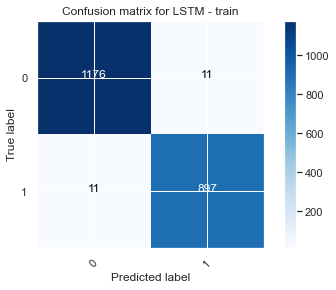

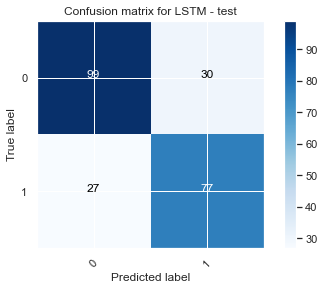

In [74]:
predictions_nn_train = model.predict(text_train)
predictions_nn_test = model.predict(text_test)

cnf_matrix_train = confusion_matrix(tag_train, predictions_nn_train.round())
cnf_matrix_test = confusion_matrix(tag_test, predictions_nn_test.round())

plt.figure()
plot_confusion_matrix(cnf_matrix_train,
                      classes=[0,1],
                      title='Confusion matrix for LSTM - train')
plt.figure()
plot_confusion_matrix(cnf_matrix_test,
                      classes=[0,1],
                      title='Confusion matrix for LSTM - test')

Compute the F1 score:
where $F1 = \frac{True Positive + True Negative}{True Positive + False Positive + True Negative + False Negative}$

In [75]:
TP = cnf_matrix_test[0][0]
TN = cnf_matrix_test[1][1]
FP = cnf_matrix_test[1][0]
FN = cnf_matrix_test[0][1]
F1 = (TP+TN)/(TP+FP+TN+FN)
print(F1)

0.7553648068669528
